# Santander Product Recommendation
In this competition, there are 1.5 years of customers behavior data from Santander bank to predict what new products customers will purchase. The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit card", "savings account", etc. The goal is to predict what additional products a customer will get in the last month, 2016-06-28, in addition to what they already have at 2016-05-28. These products are the columns named: ind_(xyz)_ult1, which are the columns #25 - #48 in the training data.

Submissions in this competition are evaluated according to the Mean Average Precision @ 7 (MAP@7). It means that it is needed to predict no more than 7 products for every customer. Note that order matters. But it depends. Order matters only if there is at least one incorrect prediction. In other words, if all predictions are correct, it doesn't matter in which order they are given. This makes sense to show up first the most relevant results.

## Abstract
1. Data exploration and visualization. Trying to understand data, to find some trends in it.
2. Data preprocessing. Preparing train and test data to put them in models. Thinking about missing values.
3. Training and predicting. Trying to apply some models.
    * Some out-of-the-box solution (i.e. XGBoost). Set the result as a baseline score.
    * Trying to beat the baseline score using Collaborative Filtering in Spark.
    * In case of enough time, expirements with Neural Networks.
4. Comparing and Analysis of the Results. 
5. Conclusions.

## Detailed Data Cleaning & Visualisation:

## First Glance
Limit the number of rows read in to avoid memory crashes with the kernel

In [57]:
from __future__ import print_function     #In order to make code compatible with Python 3 added it

#Importing libraries

#Linear Algebra Library
import numpy as np

#Data Processing, CSV file I/O
import pandas as pd

#Visualization Tool
import seaborn as sns

#Used to make changes to a matplotlib figure (Create, Plot, Decorate)
import matplotlib.pyplot as plt

#Magic functions
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6) #fitting the figure

import pickle
import gc
import xgboost

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'xgboost'

In [49]:
limit_rows   = 7000000     #limiting the rows from dataset

#Importing the dataset from CSV file from root folder
df           = pd.read_csv("train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str}, nrows=limit_rows)        #defining the datatype

#Construct a series save all user code appeared
unique_ids   = pd.Series(df["ncodpers"].unique()) 

#Sampling 12,000 of users from it
limit_people = 1.2e4


n= int(limit_people)

#Use of sample function 
unique_id    = unique_ids.sample(n)

#Conditional filtering
df           = df[df.ncodpers.isin(unique_id)]

#Statistical summary of the given dataframe
df.describe()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ncodpers,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,9.270400e+04,92359.000000,92359.0,91885.000000,92359.000000,7.619000e+04,92704.000000,92704.0,92704.000000,92704.000000,...,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92704.000000,92485.000000,92485.000000,92704.000000
mean,8.029195e+05,1.159162,1.0,26.716493,0.493942,1.332182e+05,0.000108,0.0,0.703476,0.000410,...,0.007076,0.009708,0.003085,0.059534,0.050494,0.026622,0.004940,0.057220,0.062464,0.136262
std,4.218102e+05,3.946222,0.0,12.706868,0.499966,1.509132e+05,0.010386,0.0,0.456727,0.020242,...,0.083823,0.098052,0.055458,0.236622,0.218963,0.160978,0.070115,0.232264,0.241998,0.343068
min,1.589500e+04,1.000000,1.0,1.000000,0.000000,5.130000e+03,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.224968e+05,1.000000,1.0,15.000000,0.000000,6.852897e+04,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.189960e+05,1.000000,1.0,28.000000,0.000000,1.022609e+05,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.167917e+06,1.000000,1.0,34.000000,1.000000,1.571396e+05,0.000000,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.495361e+06,99.000000,1.0,52.000000,1.000000,9.792857e+06,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have a number of demographics for each individual as well as the products they currently own. To make a test set, I will separate the last month from this training data, and create a feature that indicates whether or not a product was newly purchased. First convert the dates. There's `fecha_dato`, the row-identifier date, and `fecha_alta`, the date that the customer joined.

In [50]:
df["fecha_dato"] = pd.to_datetime(df["fecha_dato"],format="%Y-%m-%d")
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"],format="%Y-%m-%d")
df["fecha_dato"].unique()

array(['2015-01-28T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2015-04-28T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-28T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-28T00:00:00.000000000',
       '2015-09-28T00:00:00.000000000', '2015-10-28T00:00:00.000000000'],
      dtype='datetime64[ns]')

Printed the values just to double check the dates were in standard Year-Month-Day format. I expect that customers will be more likely to buy products at certain months of the year (Christmas bonuses?), so added a month column. I don't think the month that they joined matters, so just do it for one.

In [51]:
df["month"] = pd.DatetimeIndex(df["fecha_dato"]).month
df["age"]   = pd.to_numeric(df["age"], errors="coerce")

Are there any columns missing values?

In [52]:
#Check for missing values in every column
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                       True
fecha_alta                True
ind_nuevo                 True
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp


## Data Cleaning

Going down the list, start with `age`

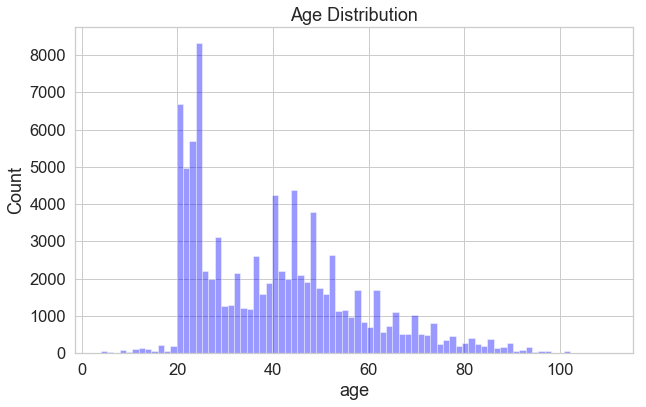

In [53]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="blue")
    plt.title("Age Distribution")
    plt.ylabel("Count")

In addition to NA, there are people with very small and very high ages.
It's also interesting that the distribution is bimodal. There are a large number of university aged students, and then another peak around middle-age. Let's separate the distribution and move the outliers to the mean of the closest one.

In [12]:
df.loc[df.age < 18,"age"]  = df.loc[(df.age >= 18) & (df.age <= 30),"age"].mean(skipna=True)
df.loc[df.age > 100,"age"] = df.loc[(df.age >= 30) & (df.age <= 100),"age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(),inplace=True)
df["age"]                  = df["age"].astype(int)

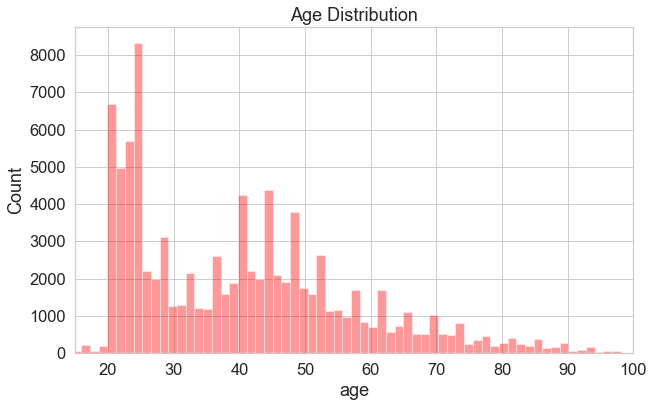

In [54]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="red")
    plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100))

#### Looks better.  

#### Next `ind_nuevo`, which indicates whether a customer is new or not. How many missing values are there?

In [15]:
df["ind_nuevo"].isnull().sum()

404

#### Let's see if we can fill in missing values by looking how many months of history these customers have.

In [16]:
months_active = df.loc[df["ind_nuevo"].isnull(),:].groupby("ncodpers", sort=False).size()
months_active.max()

6

#### Looks like these are all new customers, so replace accordingly.

In [17]:
df.loc[df["ind_nuevo"].isnull(),"ind_nuevo"] = 1

#### Now, `antiguedad`

In [18]:
df.antiguedad = pd.to_numeric(df.antiguedad,errors="coerce")
np.sum(df["antiguedad"].isnull())

404

#### That number again. Probably the same people that we just determined were new customers. Double check.

In [19]:
df.loc[df["antiguedad"].isnull(),"ind_nuevo"].describe()

count     404
unique      1
top         1
freq      404
Name: ind_nuevo, dtype: int64

#### Yup, same people. Let's give them minimum seniority.

In [20]:
df.loc[df.antiguedad.isnull(),"antiguedad"] = df.antiguedad.min()
df.loc[df.antiguedad <0, "antiguedad"]      = 0 

#### Some entries don't have the date they joined the company. Just give them something in the middle of the pack

In [21]:
dates=df.loc[:,"fecha_alta"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
df.loc[df.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
df["fecha_alta"].describe()

count                   92601
unique                   3983
top       2014-07-28 00:00:00
freq                      540
first     1995-01-16 00:00:00
last      2015-10-30 00:00:00
Name: fecha_alta, dtype: object

#### Next is `indrel`, which indicates:

> 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

#### This sounds like a promising feature. I'm not sure if primary status is something the customer chooses or the company assigns, but either way it seems intuitive that customers who are dropping down are likely to have different purchasing behaviors than others.

In [22]:
pd.Series([i for i in df.indrel]).value_counts()

1.0     92039
99.0      158
dtype: int64

#### Fill in missing with the more common status.

In [23]:
df.loc[df.indrel.isnull(),"indrel"] = 1

> tipodom	- Addres type. 1, primary address
 cod_prov	- Province code (customer's address)

#### `tipodom` doesn't seem to be useful, and the province code is not needed because the name of the province exists in `nomprov`.

In [24]:
df.drop(["tipodom","cod_prov"],axis=1,inplace=True)

#### Quick check back to see how we are doing on missing values

In [25]:
df.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme

Getting closer.

In [26]:
np.sum(df["ind_actividad_cliente"].isnull())

404

#### By now you've probably noticed that this number keeps popping up. A handful of the entries are just bad, and should probably just be excluded from the model. But for now I will just clean/keep them.

In [27]:
df.loc[df.ind_actividad_cliente.isnull(),"ind_actividad_cliente"] = \
df["ind_actividad_cliente"].median()

In [28]:
df.nomprov.unique()

array(['CIUDAD REAL', 'VALENCIA', 'GUADALAJARA', 'BARCELONA', 'TOLEDO',
       'MADRID', 'ALBACETE', 'JAEN', 'OURENSE', 'PALENCIA', 'VALLADOLID',
       'GIRONA', 'CORUÑA, A', 'ZARAGOZA', 'BALEARS, ILLES', 'CUENCA',
       'SEVILLA', 'ALMERIA', 'PONTEVEDRA', 'GRANADA', 'CANTABRIA',
       'CADIZ', 'SALAMANCA', 'CORDOBA', 'NAVARRA', 'MURCIA', 'MALAGA',
       'LUGO', 'ASTURIAS', 'CACERES', 'CASTELLON', nan, 'HUELVA',
       'BADAJOZ', 'LERIDA', 'ZAMORA', 'BURGOS', 'SORIA', 'LEON', 'HUESCA',
       'SEGOVIA', 'AVILA', 'ALICANTE', 'RIOJA, LA', 'PALMAS, LAS',
       'GIPUZKOA', 'ALAVA', 'TARRAGONA', 'BIZKAIA', 'MELILLA',
       'SANTA CRUZ DE TENERIFE', 'TERUEL', 'CEUTA'], dtype=object)

#### There was an issue with the unicode character ñ in [A Coruña](https://en.wikipedia.org/wiki/A_Coruña). I'll manually fix it, but if anybody knows a better way to catch cases like this I would be very glad to hear it in the comments.

In [29]:
df.loc[df.nomprov=="CORU\xc3\x91A, A","nomprov"] = "CORUNA, A"

#### There's some rows missing a city that I'll relabel

In [30]:
df.loc[df.nomprov.isnull(),"nomprov"] = "UNKNOWN"

#### Now for gross income, aka `renta`

In [31]:
df.renta.isnull().sum()

16277

#### Here is a feature that is missing a lot of values. Rather than just filling them in with a median, it's probably more accurate to break it down region by region. To that end, let's take a look at the median income by region, and in the spirit of the competition let's color it like the Spanish flag.

In [32]:
#df.loc[df.renta.notnull(),:].groupby("nomprov").agg([{"Sum":sum},{"Mean":mean}])
incomes = df.loc[df.renta.notnull(),:].groupby("nomprov").agg({"renta":{"MedianIncome":median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.nomprov = incomes.nomprov.astype("category", categories=[i for i in df.nomprov.unique()],ordered=False)
incomes.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


,nomprov,renta
,,MedianIncome
0,CUENCA,52659.105
1,TERUEL,57662.340
2,JAEN,58546.890
3,CIUDAD REAL,59281.560
4,BADAJOZ,62861.640


/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


([<matplotlib.axis.YTick at 0x1a63962b70>,
 <a list of 5 Text yticklabel objects>)

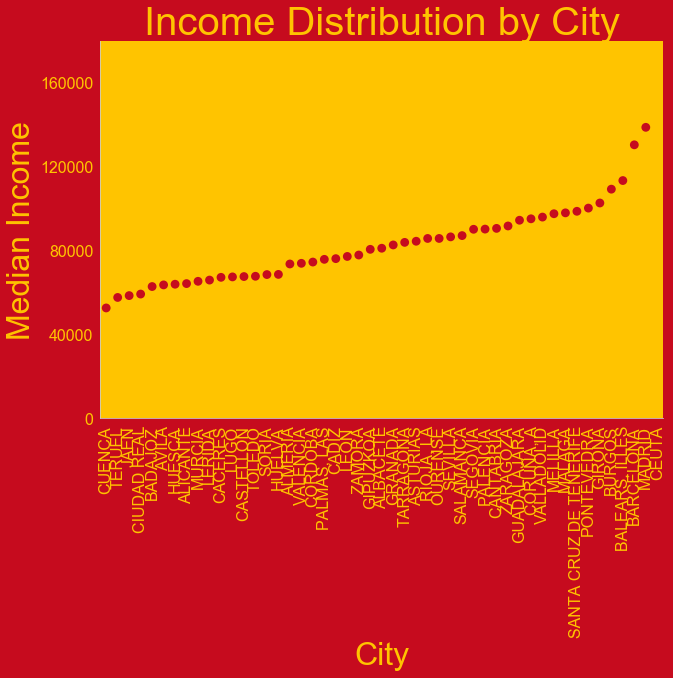

In [33]:
with sns.axes_style({
        "axes.facecolor":   "#ffc400",
        "axes.grid"     :    False,
        "figure.facecolor": "#c60b1e"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=6,
                   aspect=1.5,
                   scale=1.0,
                   color="#c60b1e",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=16,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))

#### There's a lot of variation, so I think assigning missing incomes by providence is a good idea. First group the data by city, and reduce to get the median. This intermediate data frame is joined by the original city names to expand the aggregated median incomes, ordered so that there is a 1-to-1 mapping between the rows, and finally the missing values are replaced.

In [34]:
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()

In [35]:
df.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df.renta.isnull(),"renta"].reset_index()
df.loc[df.renta.isnull(),"renta"] = df.loc[df.renta.notnull(),"renta"].median()
df.sort_values(by="fecha_dato",inplace=True)

#### The next columns with missing data I'll look at are features, which are just a boolean indicator as to whether or not that product was owned that month. Starting with `ind_nomina_ult1`..

In [36]:
df.ind_nomina_ult1.isnull().sum()

277

#### Trying to fill in missing values for products by looking at previous months, but since it's such a small number of values for now I'll take the cheap way out.

In [37]:
df.loc[df.ind_nomina_ult1.isnull(), "ind_nomina_ult1"] = 0
df.loc[df.ind_nom_pens_ult1.isnull(), "ind_nom_pens_ult1"] = 0

#### There's also a bunch of character columns that contain empty strings. For the most part, entries with NA will be converted to an unknown category.  
#### First I'll get only the columns with missing values. Then print the unique values to determine what I should fill in with.

In [38]:
string_data = df.select_dtypes(include=["object"])
missing_columns = [col for col in string_data if string_data[col].isnull().any()]
for col in missing_columns:
    print("Unique values for {0}:\n{1}\n".format(col,string_data[col].unique()))
del string_data

Unique values for ind_empleado:
['N' 'B' 'F' 'A' nan]

Unique values for pais_residencia:
['ES' nan 'IT' 'ZA' 'PR' 'GB' 'NL' 'FR' 'BO' 'AR' 'DE' 'US' 'CH' 'VE' 'PL'
 'MX' 'AU' 'EC' 'PY' 'PE' 'CU' 'CO' 'IL' 'UA' 'FI' 'MA' 'BE' 'CR']

Unique values for sexo:
['V' 'H' nan]

Unique values for ult_fec_cli_1t:
[nan '2015-07-20' '2015-07-08' '2015-07-10' '2015-07-28' '2015-07-17'
 '2015-07-29' '2015-07-03' '2015-07-27' '2015-07-30' '2015-07-07'
 '2015-07-15' '2015-07-21' '2015-08-14' '2015-08-18' '2015-08-24'
 '2015-08-19' '2015-08-17' '2015-08-05' '2015-08-28' '2015-08-20'
 '2015-08-12' '2015-08-07' '2015-08-26' '2015-08-21' '2015-09-18'
 '2015-09-07' '2015-09-22' '2015-09-21' '2015-09-09' '2015-09-28'
 '2015-09-24' '2015-09-04' '2015-09-14' '2015-09-29' '2015-09-17'
 '2015-09-15' '2015-09-10' '2015-10-20' '2015-10-29' '2015-10-09'
 '2015-10-28' '2015-10-15' '2015-10-27' '2015-10-08' '2015-10-02'
 '2015-10-26' '2015-10-05' '2015-10-06' '2015-10-07' '2015-10-13']

Unique values for indrel_1me

#### Based on that and the definitions of each variable, I will fill the empty strings either with the most common value or create an unknown category based on what I think makes more sense.

In [39]:
df.loc[df.indfall.isnull(),"indfall"] = "N"
df.loc[df.tiprel_1mes.isnull(),"tiprel_1mes"] = "A"
df.tiprel_1mes = df.tiprel_1mes.astype("category")

# As suggested by @StephenSmith
map_dict = { 1.0  : "1",
            "1.0" : "1",
            "1"   : "1",
            "3.0" : "3",
            "P"   : "P",
            3.0   : "3",
            2.0   : "2",
            "3"   : "3",
            "2.0" : "2",
            "4.0" : "4",
            "4"   : "4",
            "2"   : "2"}

df.indrel_1mes.fillna("P",inplace=True)
df.indrel_1mes = df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
df.indrel_1mes = df.indrel_1mes.astype("category")


unknown_cols = [col for col in missing_columns if col not in ["indfall","tiprel_1mes","indrel_1mes"]]
for col in unknown_cols:
    df.loc[df[col].isnull(),col] = "UNKNOWN"

#### Let's check back to see if we missed anything

In [40]:
df.isnull().any()

index                    False
fecha_dato               False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
ult_fec_cli_1t           False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
conyuemp                 False
canal_entrada            False
indfall                  False
nomprov                  False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco

Convert the feature columns into integer values (you'll see why in a second), and we're done cleaning

In [41]:
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

#### Now for the main event. To study trends in customers adding or removing services, I will create a label for each product and month that indicates whether a customer added, dropped or maintained that service in that billing cycle. I will do this by assigning a numeric id to each unique time stamp, and then matching each entry with the one from the previous month. The difference in the indicator value for each product then gives the desired value.  

In [42]:
unique_months = pd.DataFrame(pd.Series(df.fecha_dato.unique()).sort_values()).reset_index(drop=True)
unique_months["month_id"] = pd.Series(range(1,1+unique_months.size)) # start with month 1, not 0 to match what we already have
unique_months["month_next_id"] = 1 + unique_months["month_id"]
unique_months.rename(columns={0:"fecha_dato"},inplace=True)
df = pd.merge(df,unique_months,on="fecha_dato")

#### Now I'll build a function that will convert different month to month into a meaningful label. Each month, a customer can either maintain their current status with a particular product, add it or drop it.

In [43]:
def status_change(x):
    diffs = x.diff().fillna(0)# first occurrence will be considered Maintained, 
    #which is a little lazy. A better way would be to check if 
    #the earliest date was the same as the earliest we have in the dataset
    #and consider those separately. Entries with earliest dates later than that have 
    #joined and should be labeled as "Added"
    label = ["Added" if i==1 \
         else "Dropped" if i==-1 \
         else "Maintained" for i in diffs]
    return label

#### Now we can actually apply this function to each features using `groupby` followed by `transform` to broadcast the result back

In [44]:
# df.loc[:, feature_cols] = df..groupby("ncodpers").apply(status_change)
df.loc[:, feature_cols] = df.loc[:, [i for i in feature_cols]+["ncodpers"]].groupby("ncodpers").transform(status_change)

#### I'm only interested in seeing what influences people adding or removing services, so I'll trim away any instances of "Maintained".

In [45]:
df = pd.melt(df, id_vars   = [col for col in df.columns if col not in feature_cols],
            value_vars= [col for col in feature_cols])
df = df.loc[df.value!="Maintained",:]
df.shape

(7626, 28)

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


([<matplotlib.axis.YTick at 0x1a6e8d3c88>,
 <a list of 5 Text yticklabel objects>)

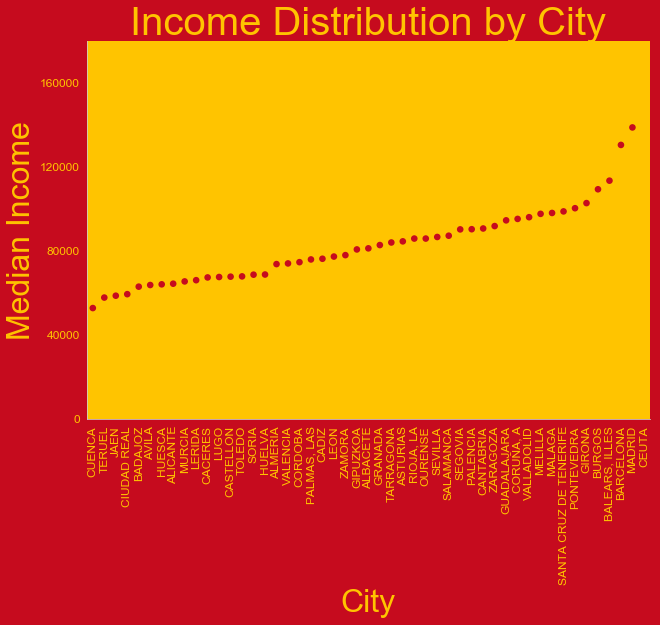

In [46]:
# For thumbnail
pylab.rcParams['figure.figsize'] = (6, 4)
with sns.axes_style({
        "axes.facecolor":   "#ffc400",
        "axes.grid"     :    False,
        "figure.facecolor": "#c60b1e"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=6,
                   aspect=1.5,
                   scale=0.75,
                   color="#c60b1e",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=12,labelcolor="#ffc400")#
plt.ylabel("Median Income",size=32,color="#ffc400")
plt.xlabel("City",size=32,color="#ffc400")
plt.title("Income Distribution by City",size=40,color="#ffc400")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))

# Conclusion- Summary Report

The goal of this model was to recommend new products to customers of Santander Bank. This was done by comparing the products that a customer had in each month with the previous month. If a customer had a new product in a given month, that month's data would be used to train the model. In order to avoid recommending products that a customer already had, the month prior to the prediction, May 2016, would be compared to the prediction month, June 2016. Any products that a customer had in May 2016 would be removed from the prediction set.

As part of the requirements for the Kaggle competition, only seven products were needed to be recommended to each customer. The seven products that were most frequently recommended were (English translations are in paraeneses): ind_recibo_ult1 (Direct Debit), ind_nom_pens_ult1 (Pensions), ind_nomina_ult1 (Payroll), ind_cco_fin_ult1 (Current Accounts), ind_tjcr_fin_ult1 (Credit Card), ind_cno_fin_ult1 (Payroll Account), and ind_ecue_fin_ult1 (e-account).

The seven most common products that customers already had were: ind_cco_fin_ult1(Current Accounts), ind_recibo_ult1 (Direct Debit), ind_ctop_fin_ult1 (Particular Account), ind_ecue_fin_ult1 (e-account), ind_cno_fin_ult1 (Payroll Account), ind_nom_pens_ult1 (Pensions), and ind_nomina_ult1 (Payroll).

Although I did not perform as well as I would have liked to, and normally do, in this Kaggle Competition, I believe that I still have a useful model. The 'Sample Submission Benchmark' score was 0.004211, my score was 0.0220795, and the winning score was 0.031409 (a like to how the score was caluclated: https://www.kaggle.com/c/santander-product-recommendation/details/evaluation). Although I scored far closer to the winning score than the Sample Submission Benchmark, there is still room for improvement. This could have been done with greater feature engineering, using cross-validation (I chose not to do this given the amount of time it would have taken to train the model), or using an ensemble of models. I joined this competition days before it finished, which gave me some time to be creative and find a useful solution, but more time would have likely been beneficial to improving my final score.

##  7.Citations

1)Seaborn tpyes:https://www.datacamp.com/community/tutorials/seaborn-python-tutorial(Reference for the concepts)

2)Matplotlib: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html    (Reference for the concepts)

3)Styling guide: http://google.github.io/styleguide/pyguide.html                    (Reference for the concepts)

4)Laggle shared as example:https://www.kaggle.com/stieranka/predicting-gdp-world-countries  (Reference for the code)

5)Seaborn: https://seaborn.pydata.org                                            (Reference for the concepts)

6)Pandas: https://pandas.pydata.org/pandas-docs/stable/index.html                (Reference for the concepts)

7)Seaborn displot:https://seaborn.pydata.org/generated/seaborn.distplot.html     (Reference for the concepts)

##  8.License

Copyright 2019 SAYALI BHAGAT

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.